In [7]:
import os
import pandas as pd
from numpy import int8, nan
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [2]:
if not os.path.exists('danone_train.pickle'):
    url_train = 'https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Danone+Hackathon+Mexico/data/train_products.json'
    dft = pd.read_json(url_train, orient='index')
    dft.to_pickle('danone_train.pickle')
    # s = df.size
    # m = df.memory_usage(deep=True)
    # print(s, m.sum()/(1024*1024))
else:
    dft=pd.read_pickle('danone_train.pickle')

In [3]:
if not os.path.exists('danone_train.pickle'):
    url_test = 'https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Danone+Hackathon+Mexico/data/test_products.json'
    df_t = pd.read_json(url_test, orient='index')
    df_t.to_pickle('danone_test.pickle')

else:
    df_t=pd.read_pickle('danone_test.pickle')

# Preprocessing

In [4]:
def get_unique_values(s: pd.Series) -> list:
    uni = []
    for i in s.tolist():
        if i not in uni:
            uni.append(i)
    return uni

In [ ]:
dft.replace(
    'unknown',
    nan,
    inplace=True
)

In [48]:
dft['is_beverage'] = dft['is_beverage'].astype(int8)

dft['additives_count'] = dft['additives_count'].astype(float)
for i in ['calcium_100g','carbohydrates_100g','energy_kcal_100g','fat_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','sugars_100g']:
    dft[i] = pd.to_numeric(dft[i])
    dft[i] = dft[i].astype(float)

In [111]:
for i in ['calcium_100g','carbohydrates_100g','energy_kcal_100g','fat_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','sugars_100g']:
    c = dft[i].corr(dft['ecoscore_grade'])
    if abs(c) > 0.05:
        print(f"{i:20}:  {c:.4f}")

calcium_100g        :  0.0610
carbohydrates_100g  :  -0.0714
energy_kcal_100g    :  0.2317
fat_100g            :  0.2534
fiber_100g          :  0.0531
proteins_100g       :  0.3997


In [60]:
u = get_unique_values(dft['selling_countries'])

In [93]:
for i in u:
    if type(i)==float:
        print(f"float: {i}")
        continue
    # else:
    #     for j in i:
    #         print(j[:2])

float: nan


In [49]:
dft.head()

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,carbohydrates_100g,energy_kcal_100g,fat_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère",NaN,"[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",1.0,NaN,21.0,NaN,7.1,2.2,2.2,0.7,0.28,0.5,b,[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.123400,0.344651,2
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour",NaN,"[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...",10.0,NaN,58.0,366.0,14.0,NaN,2.9,0.3,0.12,37.0,e,"[en:cardboard, en:plastic]",1,1.772009,0.000000,0.019531,0.288156,5.215055,0.171567,3
2,Cini Minis,"Nestlé, Nestlé",,"[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...",3.0,0.635,73.8,423.0,10.3,5.0,6.2,0.9,0.36,25.0,d,"[en:paperboard, en:plastic]",1,2.239600,0.000000,0.019531,0.281596,0.770511,0.252874,3
3,Cuor di fette Carrefour,Carrefour,NaN,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",2.0,NaN,8.5,NaN,19.0,0.0,15.0,2.5,1.00,8.5,e,[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,Curry,"Carrefour,Groupe Carrefour",NaN,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....",0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,NaN,"[en:glass, en:plastic, en:unknown]",0,7.918371,0.000000,0.015709,0.478390,0.445327,0.334988,4


In [50]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20835 entries, 0 to 20834
Data columns (total 28 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   name                                                  20507 non-null  object 
 1   brand                                                 20835 non-null  object 
 2   generic_name                                          2211 non-null   object 
 3   categories_hierarchy                                  20835 non-null  object 
 4   is_beverage                                           20835 non-null  int8   
 5   selling_countries                                     20832 non-null  object 
 6   ingredient_origins                                    20835 non-null  object 
 7   ingredients                                           15681 non-null  object 
 8   additives_count                                       15

In [30]:
# Adding up of ingredients origin
uni = get_unique_values(dft['ingredient_origins'])
pt = 101.7

if all(
    [
        sum(
            [float(i) for i in list(i.values())]
        ) <= pt
        for i
        in uni
    ]
):
    print(f'Percentages add up to less than {pt} %')

Percentages add up to less than 101.7 %


In [32]:
# Found: generic name repeats 21 times, it only changes origin and destination, but the score remains the same, how so? I think it is not taken into acccount the transportation
get_unique_values(dft.loc[dft['generic_name']=='Superior quality dried pasta.', :]['ingredient_origins'])

[{'en:unknown': 100},
 {'en:european-union-and-non-european-union': 100},
 {'en:spain': 100},
 {'en:italy': 100}]

# Model

In [113]:
relevant_features=[
    'calcium_100g',
    'carbohydrates_100g',
    'energy_kcal_100g',
    'fat_100g',
    'fiber_100g',
    'proteins_100g',
    'est_co2_agriculture',
    'est_co2_consumption',
    'est_co2_distribution',
    'est_co2_packaging',
    'est_co2_processing',
    'est_co2_transportation'
    ]

X = dft[relevant_features].to_numpy()
y = dft[['ecoscore_grade']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [114]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [115]:
clf = \
    PassiveAggressiveClassifier(
        max_iter=10000,
        #random_state=0,
        tol=1e-4
    )
clf.fit(X, y)
clf.score(X, y)

c:\Users\alfre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Input X contains NaN.
PassiveAggressiveClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [138]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.XGBClassifier(
    tree_method="gpu_hist",
    rounds=10,
    n_estimators=500,
    max_depth=10,
    eval_metric='mlogloss',
    min_child_weight=0.02,
    reg_lambda=0.01
)
es = xgb.callback.EarlyStopping(
    rounds=3,
    save_best=True,
    maximize=False,
    data_name="validation_0",
    metric_name="mlogloss",
)
bst

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=0.02, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [139]:
bst.fit(
    X,
    y,
    eval_set=[(X, y)],
    callbacks=[es])

c:\Users\alfre\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[01:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "rounds" } are not used.

[0]	validation_0-mlogloss:1.19545
[1]	validation_0-mlogloss:0.96909
[2]	validation_0-mlogloss:0.81973
[3]	validation_0-mlogloss:0.71442
[4]	validation_0-mlogloss:0.63659
[5]	validation_0-mlogloss:0.57843
[6]	validation_0-mlogloss:0.53070
[7]	validation_0-mlogloss:0.49402
[8]	validation_0-mlogloss:0.46448
[9]	validation_0-mlogloss:0.44132
[10]	validation_0-mlogloss:0.42328
[11]	validation_0-mlogloss:0.40768
[12]	validation_0-mlogloss:0.39460
[13]	validation_0-mlogloss:0.38388
[14]	validation_0-mlogloss:0.37452
[15]	validation_0-mlogloss:0.36734
[16]	validation_0-mlogloss:0.36008
[17]	validation_0-mlogloss:0.35383
[18]	validation_0-mlogloss:0.34853
[19]	validation_0-mlogloss:0.34246
[20]	validation_0-mlogloss:0.33745
[21]	validation_0-mlogloss:0.33169
[22]	validation_0-mlogloss:0.32599
[23]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=0.02, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [140]:
y_true = y_test
y_pred = bst.predict(X_test)
f1_score(
    y_true=y_true,
    y_pred=y_pred,
    average='weighted'
)

0.9532247842936901

In [90]:
import pprint

In [93]:
for i in ['calcium_100g', 'carbohydrates_100g', 'energy_kcal_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
          'sodium_100g', 'sugars_100g', 'nutrition_grade', 'packaging_materials']:
    pprint.pprint(dft[i].value_counts()[:10])#.replace('unknown',)

unknown                19888
0.12                     171
0                         62
1                         13
0.5                       11
0.071                     10
0.13                       9
0.18                       8
0.47900000000000004        7
0.15                       7
Name: calcium_100g, dtype: int64
unknown               2277
0                     1074
0.5                    541
1                      409
12                     360
11                     352
0.6000000000000001     275
13                     241
0.7000000000000001     210
59                     193
Name: carbohydrates_100g, dtype: int64
unknown    4842
0           245
46           98
4            88
1            88
47           80
400          76
63           70
38           69
125          66
Name: energy_kcal_100g, dtype: int64
unknown    2335
0          1685
0.5         980
12          325
11          309
15          277
23          274
10          248
21          248
14          245
Name: fat_1

In [ ]:
dft.

In [85]:
dft['ecoscore_grade'].corr(dft['calcium_100g'])

TypeError: can only concatenate str (not "float") to str

In [84]:
dft.select_dtypes(object)

,name,brand,generic_name,categories_hierarchy,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,carbohydrates_100g,energy_kcal_100g,fat_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,nutrition_grade,packaging_materials
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère",unknown,"[en:frozen-foods, en:frozen-fried-potatoes, en...",[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",1,unknown,21,unknown,7.1,2.2,2.2,0.7,0.28,0.5,b,[en:plastic]
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour",unknown,"[en:snacks, en:desserts, en:sweet-snacks, en:f...",[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...",10,unknown,58,366,14,unknown,2.9,0.3,0.12,37,e,"[en:cardboard, en:plastic]"
2,Cini Minis,"Nestlé, Nestlé",,"[en:plant-based-foods-and-beverages, en:plant-...","[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...",3,0.635,73.8,423,10.3,5,6.2,0.9,0.36,25,d,"[en:paperboard, en:plastic]"
3,Cuor di fette Carrefour,Carrefour,unknown,"[en:dairies, en:fermented-foods, en:fermented-...",[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",2,unknown,8.5,unknown,19,0,15,2.5,1,8.5,e,[en:plastic]
4,Curry,"Carrefour,Groupe Carrefour",unknown,"[en:plant-based-foods-and-beverages, en:plant-...",[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....",0,unknown,0,0,0,0,0,0,0,0,unknown,"[en:glass, en:plastic, en:unknown]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,jus de pommes,Carrefour,unknown,"[en:plant-based-foods-and-beverages, en:bevera...",[en:france],{'en:france': 100},"[{'id': 'en:apple-juice', 'labels': 'en:organi...",0,unknown,10,40,unknown,unknown,unknown,unknown,unknown,9.8,unknown,[en:unknown]
20831,Cafe soluble tueste natural,Eroski,unknown,"[en:plant-based-foods-and-beverages, en:bevera...",[en:spain],{'en:unknown': 100},unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,[en:unknown]
20832,Cioccolato fondente con nocciole intere,Carrefour,unknown,"[en:snacks, en:sweet-snacks, en:cocoa-and-its-...",[en:italy],{'en:unknown': 100},unknown,unknown,unknown,34,592,45,8.6,8.5,0,0,30,d,[en:unknown]
20833,BEURRE MOULÉ DE Bretagne Demi sel,Carrefour,unknown,"[en:dairies, en:fats, en:spreads, en:spreadabl...",[en:france],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:crea...",0,unknown,0.6,725,80,0,0.7,2,0.8,0.6,e,[en:plastic]


In [38]:
for i in dft['name'].str.lower().unique():
    print(i)

pommes duchesse
bûche pâtissière à la crème au beurre
cini minis
cuor di fette carrefour
curry
extra fin noir croustillant
mayonnaise
dés de saumon fumé
pomme mangue sans sucres ajoutés*
filets de hareng ronde des mers doux sachet
hogaza centeno y avena
sauce burger
le limousin façon bouchère
assortiment de macarons citron - cassis - framboise - abricot x 12
maasdam moelleux
100% pur jus de pomme
granola con manzana y canela
brownies au chocolat
panna cotta à la framboise
préparation pour crème brûlée
nescafé espresso
vinaigrette moutarde à l'ancienne
melkehjerter
crunchy muesli lion
sablés coeur saveur pomme façon tatin
erdnussbutter creamy
biscuits petit déjeuner choco-noisette
pur jus multifruits kids
nestlé gastro protect
iced tea
rillettes de sardines au citron et basilic
farine de blé
gourmandises aux 3 chocolats
croustilles
gaspacho suave
riche en omega 3
saumon fumé de norvège label rouge x 2 tranches
jus de pamplemousse rose
croque-monsieur
carrefour  dosettes  café  cappuccin

In [32]:
for i in df.columns:
    print(df[i].nunique())

16723
2153
264


TypeError: unhashable type: 'list'

In [29]:
for i in df['brand'].unique():
    print(i)

Pom lisse,Pom'Lisse, Marque Repère
Esprit de Fête,Carrefour
Nestlé, Nestlé
Carrefour
Carrefour,Groupe Carrefour
Côte d'Or,Mondelez
Winiary,Nestlé
Carrefour Bio,Carrefour
Ronde des Mers,Marque Repère, Pêche Océan
eroski
Carrefour, Saxo
Marque Repère, Trofic
Les Croisés,Marque Repère
Maizena,Unilever
P'tit Déli,Marque Repère
Nestlé, Nescafe
Freia,Mondelez
Nestlé,Lion
Calvé,Unilever
Bio Village,Marque Repère
Nestlé
Lipton,  Unilever
Ronde des Mers,Marque Repère
Belin,Mondelez
Marque Repère,Ronde des Mers
Carrefour,CMI (Carrefour Marchandises Internationales),Groupe Carrefour
Kraft
Lu,Mondelez
Tablette d'Or,Marque Repère
Tradilège,Marque Repère,Scamark (Filiale E. Leclerc)
Délisse,Marque Repère
Eroski
La Laitière,Nestlé
Côté Snack,Marque Repère
Nestlé,Les Recettes de l'Atelier
Bon app',Carrefour
Tokapi,Marque Repère
Hellman's,Unilever
Turini,Marque Repère
Rustica,Marque Repère
Pêche Océan,Marque Repère
Mondelez
kraft
Tokapi,Marque Repère,Scamark (Filiale E. Leclerc)
Terrabusi,Mondelez
Milk

<AxesSubplot:ylabel='Density'>

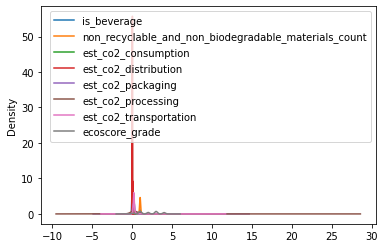

In [25]:
df.plot(
    x='est_co2_agriculture',
    #y='ecoscore_grade',
    kind='kde'
    )